<a href="https://colab.research.google.com/github/Ninja-State/NMA-DL-Project/blob/Katya/tsne_Steinmetz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
#@title Imports

import os, requests

import time
import copy
import torch
import torchvision
import  sklearn

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import numpy as np
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib import rcParams

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets

from tqdm.auto import tqdm

In [2]:
#@title Clone FFT-accelerated t-SNE
!git clone https://github.com/KlugerLab/FIt-SNE.git 

Cloning into 'FIt-SNE'...
remote: Enumerating objects: 922, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 922 (delta 74), reused 64 (delta 23), pack-reused 780
Receiving objects: 100% (922/922), 31.93 MiB | 21.39 MiB/s, done.
Resolving deltas: 100% (513/513), done.


In [3]:
!apt-get install libfftw3-dev
!g++ -std=c++11 -O3  /content/FIt-SNE/src/sptree.cpp /content/FIt-SNE/src/tsne.cpp /content/FIt-SNE/src/nbodyfft.cpp  -o /content/FIt-SNE/bin/fast_tsne -pthread -lfftw3 -lm -Wno-address-of-packed-member

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-long3 libfftw3-quad3 libfftw3-single3
0 upgraded, 5 newly installed, 0 to remove and 40 not upgraded.
Need to get 3,766 kB of archives.
After this operation, 21.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libfftw3-long3 amd64 3.3.7-1 [308 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libfftw3-quad3 amd64 3.3.7-1 [552 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libfftw3-single3 amd64 3.3.7-1 [764 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/main amd64 libfftw3-bin amd64 3.3.7-1 [32.7 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic/main amd64 libfftw3-dev amd64 3.3.7-1 [

In [4]:
import os
import sys

sys.path.append(os.path.abspath('/content/FIt-SNE/'))

from fast_tsne import fast_tsne 

In [5]:
#@title Plotting params

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

# Example of running fast t-SNE on MNIST dataset
[link text](https://github.com/KlugerLab/FIt-SNE/blob/master/examples/test.ipynb)

In [65]:
import numpy as np
import pylab as plt
import seaborn as sns
sns.set_style('ticks')

# the path should point to the FIt-SNE directory
import sys; sys.path.append('../')
from fast_tsne import fast_tsne

In [66]:
# Load MNIST data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
X = mnist.data
y = mnist.target.astype('int')
print(X.shape)

# Do PCA and keep 50 dimensions
X = X - X.mean(axis=0)
U, s, V = np.linalg.svd(X, full_matrices=False)
X50 = np.dot(U, np.diag(s))[:,:50]

# 10 nice colors
col = np.array(['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99',
                '#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a'])

(70000, 784)


CPU times: user 1.15 s, sys: 338 ms, total: 1.49 s
Wall time: 2min 13s


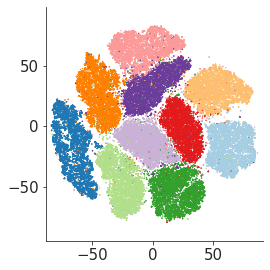

In [67]:
%time Z = fast_tsne(X50)

plt.figure(figsize=(4,4))
plt.axis('equal')
plt.scatter(Z[:,0], Z[:,1], c=col[y], s=2, edgecolors='none')
sns.despine()
plt.tight_layout()

# Load and visualize Steinmetz dataset

In [6]:
#@title Loading Spike times

fname1 = ['steinmetz_st.npz']
fname1.append('steinmetz_wav.npz')
fname1.append('steinmetz_lfp.npz')
url2 = ["https://osf.io/4bjns/download"]
url2.append("https://osf.io/ugm9v/download")
url2.append("https://osf.io/kx3v9/download")


for j in range(len(url2)):
  if not os.path.isfile(fname1[j]):
    try:
      r = requests.get(url2[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname1[j], "wb") as fid:
          fid.write(r.content)


dat_ST = np.load('steinmetz_st.npz', allow_pickle=True)['dat']
dat2 = dat_ST[11]
del dat_ST
#print(dat2.keys())

In [7]:
#@title Load binned spike times

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11] # pick dataset 11
#print(dat.keys())

In [8]:
#@title DF form
dt_waveforms = 1/30000 # dt of waveform
binsize = dat['bin_size'] # bin times spikes
mean_firing = dat['spks'].mean(axis = (1,2)) * 1/binsize # computing mean firing rate
t_t_peak = dat['trough_to_peak'] * dt_waveforms * 1e3 # computing trough to peak time in ms


labeling_df = pd.DataFrame({
    "Mean Firing Rate": mean_firing,
    "Trough to peak": t_t_peak,
    "Region": dat['brain_area'],
    "Area":dat['brain_area']
})
labeling_df.replace(
    {
        "Area": {"CA1":"Hippocampus","DG":"Hippocampus","SUB":"Hippocampus",
        "VISp": "Visual Ctx", "VISam":"Visual Ctx","MD":"Thalamus","LGd":"Thalamus", "LH":"Thalamus",
        "PL":"Other Ctx","MOs":"Other Ctx","ACA":"Other Ctx"
        }
    }, inplace = True
)

# Labeling according to conditions, other is the default condition
labeling_df['Cell Type'] = "Other"
labeling_df.loc[(labeling_df['Mean Firing Rate']<5)&(labeling_df['Trough to peak']>0.4),'Cell Type'] = "Excitatory"
labeling_df.loc[(labeling_df['Mean Firing Rate']>5)&(labeling_df['Trough to peak']<0.4), 'Cell Type'] = "Inhibitory"

labeling_df.head(20)

,Mean Firing Rate,Trough to peak,Region,Area,Cell Type
0,0.731765,0.800000,VISp,Visual Ctx,Excitatory
1,0.237647,0.666667,VISp,Visual Ctx,Excitatory
2,5.368235,0.766667,VISp,Visual Ctx,Other
3,0.190588,0.566667,DG,Hippocampus,Excitatory
4,1.356471,0.633333,VISp,Visual Ctx,Excitatory
5,0.000000,0.733333,VISp,Visual Ctx,Excitatory
6,0.141176,0.600000,SUB,Hippocampus,Excitatory
7,2.327059,0.733333,DG,Hippocampus,Excitatory
8,0.030588,0.633333,VISp,Visual Ctx,Excitatory
9,0.798824,0.400000,VISp,Visual Ctx,Other


In [14]:
#@title Raster visualizer

from ipywidgets import interact
import ipywidgets as widgets

vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
is_correct = np.sign(dat['response'])==np.sign(vis_left-vis_right)
def raster_visualizer(area,trial):
  spikes= dat2['ss']
  plt.figure(figsize=(9,5))
  plt.eventplot(spikes[labeling_df['Area']==area][:,trial],color='k')
  #plt.eventplot(spikes[(labeling_df['Area']==area) & (labeling_df['Cell Type']=='Excitatory')][:,trial]);
  #plt.eventplot(spikes[(labeling_df['Area']==area) & (labeling_df['Cell Type']=='Other')][:,trial],color='k');
  #plt.eventplot(spikes[(labeling_df['Area']==area) & (labeling_df['Cell Type']=='Inhibitory')][:,trial],colors = 'r');
  plt.yticks([]);
  plt.vlines(0.5,0,len(spikes[(labeling_df['Area']==area)])-10,'red','--',alpha=0.5)
  plt.ylabel('Neurons');
  plt.xlabel('Time ($s$)');
  plt.title(f'Trial was correct?:{is_correct[trial]}')
interact(raster_visualizer, area=['Hippocampus','Visual Ctx','Thalamus','Other Ctx'], trial=(0,339));

interactive(children=(Dropdown(description='area', options=('Hippocampus', 'Visual Ctx', 'Thalamus', 'Other Ct…

# Calculate ISI percentiles and try t-SNE

In [55]:
#@title calculate ISI percentiles

spikes= dat2['ss']

#spk = spikes[labeling_df['Region']=='VISp']
#spk = spikes[labeling_df['Region']=='CA1']
spk = spikes[labeling_df['Area']=='Visual Ctx']

isiPercentile=[]

for j in range(0,spk.shape[1]): # by trials
  for i in range(0,spk.shape[0]): # by neurons
    isi = np.diff(spk[i,j])
    if len(isi)!=0: # if neuron is spiking
      per_isi=np.percentile(isi,np.linspace(0, 100, 10))
    else:
      per_isi=np.zeros(10)

    isiPercentile.append(per_isi)

isiPercentile2=np.hstack(isiPercentile)
isiPercentileAll = isiPercentile2.reshape(spk.shape[1],spk.shape[0]*10)



<BarContainer object of 10 artists>

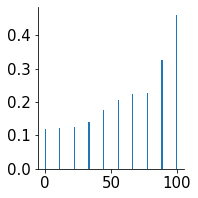

In [63]:
#@title Example ISI percentile plots
plt.figure(figsize=(3,3))
plt.bar(np.linspace(0, 100, 10),isiPercentile[14])

CPU times: user 95 ms, sys: 72.4 ms, total: 167 ms
Wall time: 7.31 s


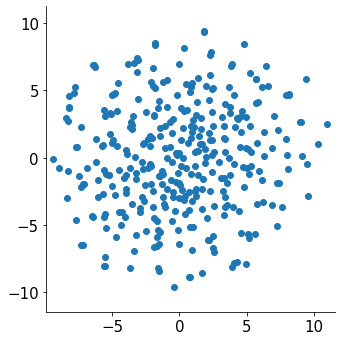

In [64]:
#@title try fast t-SNE
%time Z = fast_tsne(isiPercentileAll)

plt.figure(figsize=(5,5))
plt.axis('equal')
plt.scatter(Z[:,0], Z[:,1])
#plt.scatter(Z[:,0], Z[:,1], c=col[y], s=2, edgecolors='none')
#sns.despine()
plt.tight_layout()

# Calculate spike distances and try t-SNE